In [33]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import h5py
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
import pydot
from IPython.display import SVG
import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from keras.regularizers import l1, l2
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from PIL import Image

In [2]:
def load_dataset(path_to_train, path_to_test):
    train_dataset = h5py.File(path_to_train)
    train_x = np.array(train_dataset['train_set_x'][:])
    train_y = np.array(train_dataset['train_set_y'][:])

    test_dataset = h5py.File(path_to_test)
    test_x = np.array(test_dataset['test_set_x'][:])
    test_y = np.array(test_dataset['test_set_y'][:])


    return train_x, train_y, test_x, test_y

![Texte alternatif…](https://raw.githubusercontent.com/Kulbear/deep-learning-coursera/master/Convolutional%20Neural%20Networks/images/house-members.png)

1) Load Dataset and normalize image vectors

In [3]:
X_train_valid, Y_train_valid, X_test, Y_test = load_dataset("train_happy.h5","test_happy.h5")

# Get the shape of the training and testing images arrays
X_train_valid_shape = X_train_valid.shape
X_test_shape = X_test.shape

print("Shape of X_train_valid:", X_train_valid_shape)
print("Shape of X_test:", X_test_shape)


Shape of X_train_valid: (600, 64, 64, 3)
Shape of X_test: (150, 64, 64, 3)


In [4]:
# Construct a validation set from the last 10000 images and labels from
# train_and_validation_images and train_and_validation_labels
X_valid = X_train_valid[-150:, :, :]
Y_valid = Y_train_valid[-150:]

# Construct a training set from the first 50000 images and labels.
X_train = X_train_valid[:450, :, :]
Y_train = Y_train_valid[:450]

2) Sample a random image and print it

In [5]:
print(X_train[0])

[[[178 190 163]
  [172 181 173]
  [188 196 184]
  ...
  [255 255 254]
  [254 255 250]
  [249 253 222]]

 [[184 201 165]
  [149 154 142]
  [149 158 139]
  ...
  [255 255 253]
  [254 255 250]
  [251 255 230]]

 [[198 207 165]
  [141 147 128]
  [168 184 154]
  ...
  [253 255 244]
  [254 255 248]
  [253 255 233]]

 ...

 [[ 77  82  89]
  [ 60  64  68]
  [ 49  53  55]
  ...
  [ 31  32  30]
  [ 47  48  46]
  [ 75  75  75]]

 [[ 68  71  76]
  [ 55  58  59]
  [ 44  47  47]
  ...
  [ 30  31  29]
  [ 40  41  39]
  [ 63  64  63]]

 [[ 61  64  66]
  [ 52  54  54]
  [ 45  47  46]
  ...
  [ 30  31  29]
  [ 38  38  36]
  [ 56  56  54]]]


In [6]:
# Normalize

print('Le max de train_images = {} et le min = {}'.format(X_train.max(), X_train.min()))
X_train = X_train/255.
X_valid = X_valid/255.
X_test = X_test/255.

Le max de train_images = 255 et le min = 1


In [7]:
print(X_train[0])

[[[0.69803922 0.74509804 0.63921569]
  [0.6745098  0.70980392 0.67843137]
  [0.7372549  0.76862745 0.72156863]
  ...
  [1.         1.         0.99607843]
  [0.99607843 1.         0.98039216]
  [0.97647059 0.99215686 0.87058824]]

 [[0.72156863 0.78823529 0.64705882]
  [0.58431373 0.60392157 0.55686275]
  [0.58431373 0.61960784 0.54509804]
  ...
  [1.         1.         0.99215686]
  [0.99607843 1.         0.98039216]
  [0.98431373 1.         0.90196078]]

 [[0.77647059 0.81176471 0.64705882]
  [0.55294118 0.57647059 0.50196078]
  [0.65882353 0.72156863 0.60392157]
  ...
  [0.99215686 1.         0.95686275]
  [0.99607843 1.         0.97254902]
  [0.99215686 1.         0.91372549]]

 ...

 [[0.30196078 0.32156863 0.34901961]
  [0.23529412 0.25098039 0.26666667]
  [0.19215686 0.20784314 0.21568627]
  ...
  [0.12156863 0.1254902  0.11764706]
  [0.18431373 0.18823529 0.18039216]
  [0.29411765 0.29411765 0.29411765]]

 [[0.26666667 0.27843137 0.29803922]
  [0.21568627 0.22745098 0.23137255]


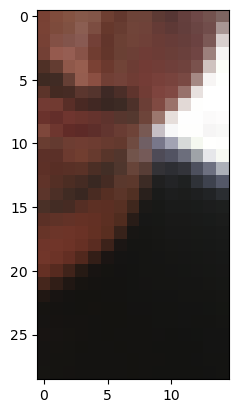

In [8]:
plt.imshow(X_train[0,35:450,35:50])
plt.show()

3) Build the model and fit it

_________________________________________________________________

conv2d_3 (Conv2D)            (None, 64, 64, 32)        4736      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 32769     
_________________________________________________________________



In [9]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [10]:
# Create a Sequential model
model_adam = Sequential()

# Conv2D layer
model_adam.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3), kernel_regularizer=l1(0.01), name='conv2d_3'))

# BatchNormalization layer
model_adam.add(BatchNormalization(name='batch_normalization_2'))

# MaxPooling2D layer
model_adam.add(MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_2'))

# Flatten layer
model_adam.add(Flatten(name='flatten_2'))

# Dense layer
model_adam.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01), name='dense_2'))

# Display the model summary
model_adam.summary()


model_adam.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

history_adam = model_adam.fit(X_train, Y_train,
                    batch_size=128,
                    epochs=20,
                    verbose=1,
                    validation_data=(X_valid, Y_valid),
                    callbacks=[early_stopping])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 batch_normalization_2 (Bat  (None, 62, 62, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 30752)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 30753     
                                                                 
Total params: 31777 (124.13 KB)
Trainable params: 31713 

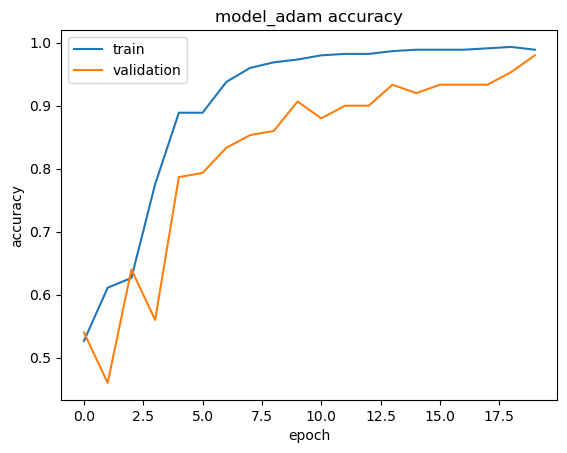

In [11]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history_adam.history['accuracy'])
plt.plot(history_adam.history['val_accuracy'])
plt.title('model_adam accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [12]:
# Create a Sequential model
model_SGD = Sequential()

# Conv2D layer
model_SGD.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3), kernel_regularizer=l1(0.01), name='conv2d_3'))

# BatchNormalization layer
model_SGD.add(BatchNormalization(name='batch_normalization_2'))

# MaxPooling2D layer
model_SGD.add(MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_2'))

# Flatten layer
model_SGD.add(Flatten(name='flatten_2'))

# Dense layer
model_SGD.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01), name='dense_2'))

# Display the model summary
model_SGD.summary()


model_SGD.compile(optimizer = 'SGD',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

history_SGD = model_SGD.fit(X_train, Y_train,
                    batch_size=128,
                    epochs=20,
                    verbose=1,
                    validation_data=(X_valid, Y_valid), 
                    callbacks=[early_stopping])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 batch_normalization_2 (Bat  (None, 62, 62, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 30752)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 30753     
                                                                 
Total params: 31777 (124.13 KB)
Trainable params: 3171

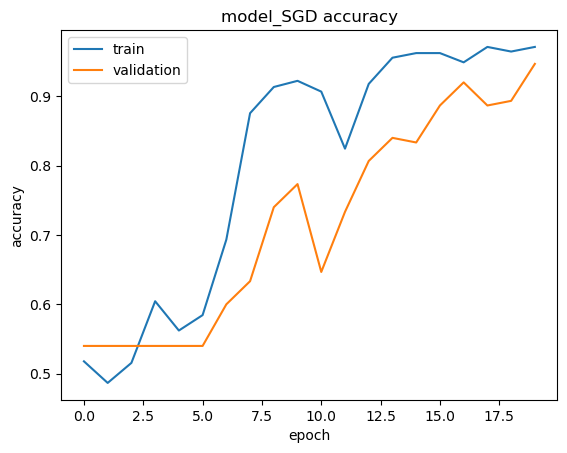

In [13]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history_SGD.history['accuracy'])
plt.plot(history_SGD.history['val_accuracy'])
plt.title('model_SGD accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [14]:
# Create a Sequential model
model_RMSprop = Sequential()

# Conv2D layer
model_RMSprop.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3), kernel_regularizer=l1(0.01), name='conv2d_3'))

# BatchNormalization layer
model_RMSprop.add(BatchNormalization(name='batch_normalization_2'))

# MaxPooling2D layer
model_RMSprop.add(MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_2'))

# Flatten layer
model_RMSprop.add(Flatten(name='flatten_2'))

# Dense layer
model_RMSprop.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01), name='dense_2'))

# Display the model summary
model_RMSprop.summary()


model_RMSprop.compile(optimizer = 'RMSprop',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

history_RMSprop = model_RMSprop.fit(X_train, Y_train,
                    batch_size=128,
                    epochs=20,
                    verbose=1,
                    validation_data=(X_valid, Y_valid), 
                    callbacks=[early_stopping])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 batch_normalization_2 (Bat  (None, 62, 62, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 30752)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 30753     
                                                                 
Total params: 31777 (124.13 KB)
Trainable params: 3171

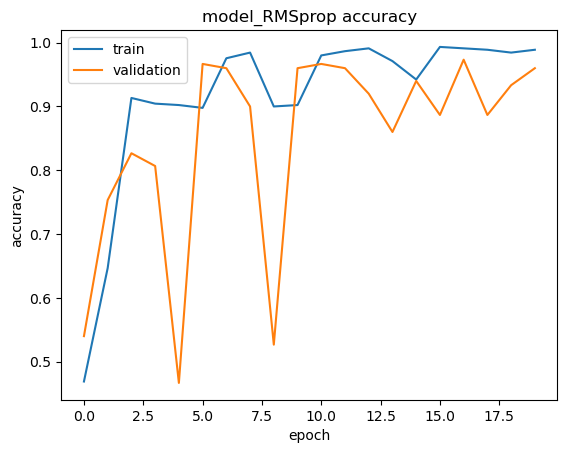

In [15]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history_RMSprop.history['accuracy'])
plt.plot(history_RMSprop.history['val_accuracy'])
plt.title('model_RMSprop accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

4) Evaluate the models

In [16]:
val_loss_adam, val_acc_adam = model_adam.evaluate(X_test, Y_test)
print('val_loss_adam: ', round(val_loss_adam,3),'     val_acc_adam: ', round(val_acc_adam,3))

5/5 [==============================] - 0s 12ms/step - loss: 0.9721 - accuracy: 0.9200
val_loss_adam:  0.972      val_acc_adam:  0.92


In [17]:
val_loss_SGD, val_acc_SGD = model_SGD.evaluate(X_test, Y_test)
print('val_loss_SGD: ', round(val_loss_SGD,3),'     val_acc_SGD: ', round(val_acc_SGD,3))

5/5 [==============================] - 0s 15ms/step - loss: 1.1061 - accuracy: 0.8667
val_loss_SGD:  1.106      val_acc_SGD:  0.867


In [18]:
val_loss_RMSprop, val_acc_RMSprop = model_RMSprop.evaluate(X_test, Y_test)
print('val_loss_RMSprop: ', round(val_loss_RMSprop,3),'     val_acc_RMSprop: ', round(val_acc_RMSprop,3))

5/5 [==============================] - 0s 15ms/step - loss: 0.9904 - accuracy: 0.9600
val_loss_RMSprop:  0.99      val_acc_RMSprop:  0.96


5) Give the Confusion Matrix and the classification_report

In [29]:
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have already trained the model

# Make predictions on the test set
Y_pred_adam = model_adam.predict(X_test)

# Threshold the predictions for binary classification
Y_pred_binary = (Y_pred_adam > 0.5).astype(int)

# Convert Y_test to binary (if it's not already)
Y_test_binary = Y_test.astype(int)

# Calculate confusion matrix
conf_matrix = confusion_matrix(Y_test_binary, Y_pred_binary)

# Print confusion matrix
print("Confusion Matrix Adam:")
print(conf_matrix)

# Generate and print classification report
class_report = classification_report(Y_test_binary, Y_pred_binary)
print("\nClassification Report Adam:")
print(class_report)


5/5 [==============================] - 0s 10ms/step
Confusion Matrix Adam:
[[64  2]
 [10 74]]

Classification Report Adam:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91        66
           1       0.97      0.88      0.93        84

    accuracy                           0.92       150
   macro avg       0.92      0.93      0.92       150
weighted avg       0.93      0.92      0.92       150



In [30]:
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have already trained the model

# Make predictions on the test set
Y_pred_SGD = model_SGD.predict(X_test)

# Threshold the predictions for binary classification
Y_pred_binary = (Y_pred_SGD > 0.5).astype(int)

# Convert Y_test to binary (if it's not already)
Y_test_binary = Y_test.astype(int)

# Calculate confusion matrix
conf_matrix = confusion_matrix(Y_test_binary, Y_pred_binary)

# Print confusion matrix
print("Confusion Matrix SGD:")
print(conf_matrix)

# Generate and print classification report
class_report = classification_report(Y_test_binary, Y_pred_binary)
print("\nClassification Report SGD:")
print(class_report)


5/5 [==============================] - 0s 12ms/step
Confusion Matrix SGD:
[[62  4]
 [16 68]]

Classification Report SGD:
              precision    recall  f1-score   support

           0       0.79      0.94      0.86        66
           1       0.94      0.81      0.87        84

    accuracy                           0.87       150
   macro avg       0.87      0.87      0.87       150
weighted avg       0.88      0.87      0.87       150



In [31]:
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have already trained the model

# Make predictions on the test set
Y_pred_RMSprop = model_RMSprop.predict(X_test)

# Threshold the predictions for binary classification
Y_pred_binary = (Y_pred_RMSprop > 0.5).astype(int)

# Convert Y_test to binary (if it's not already)
Y_test_binary = Y_test.astype(int)

# Calculate confusion matrix
conf_matrix = confusion_matrix(Y_test_binary, Y_pred_binary)

# Print confusion matrix
print("Confusion Matrix RMSprop:")
print(conf_matrix)

# Generate and print classification report
class_report = classification_report(Y_test_binary, Y_pred_binary)
print("\nClassification Report RMSprop:")
print(class_report)


5/5 [==============================] - 0s 10ms/step
Confusion Matrix RMSprop:
[[62  4]
 [ 2 82]]

Classification Report RMSprop:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95        66
           1       0.95      0.98      0.96        84

    accuracy                           0.96       150
   macro avg       0.96      0.96      0.96       150
weighted avg       0.96      0.96      0.96       150



6) Note


* Used different regularizataion techniques

---
* Compared different optimizers

---

* Displaying images with Predicted & expected labels (Happy-sad)


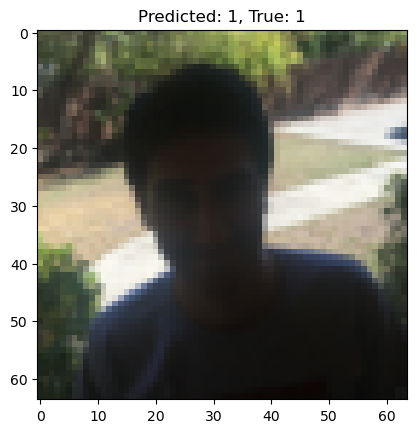

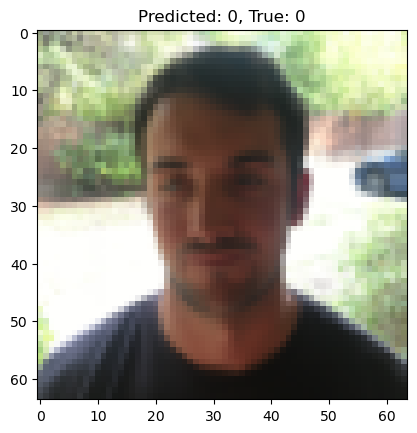

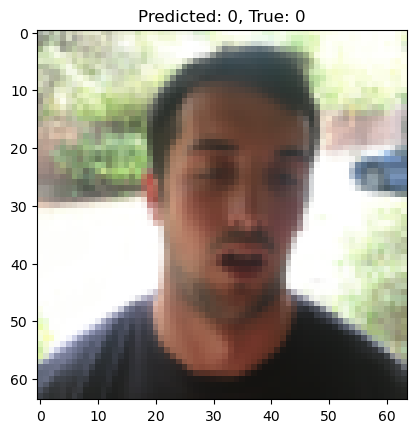

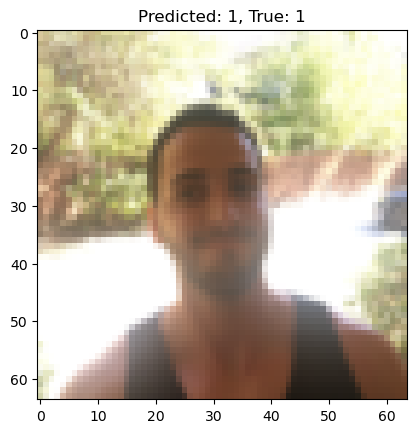

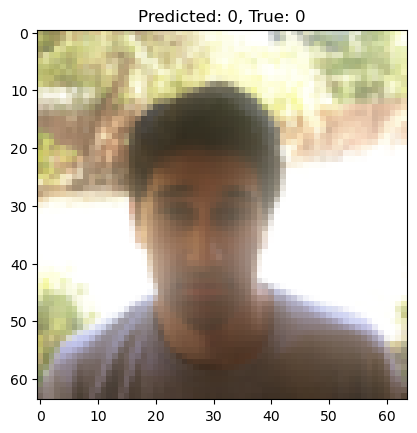

In [22]:
# Convert predicted probabilities to binary labels (0 for sad, 1 for happy)
predicted_labels = np.round(Y_pred_adam)

# Display a random sample of images with predicted and true labels
num_samples = 5
random_indices = np.random.choice(range(len(X_test)), num_samples, replace=False)

for index in random_indices:
    # Display the image
    plt.imshow(X_test[index])
    plt.title(f'Predicted: {int(predicted_labels[index])}, True: {int(Y_test[index])}')
    plt.show()


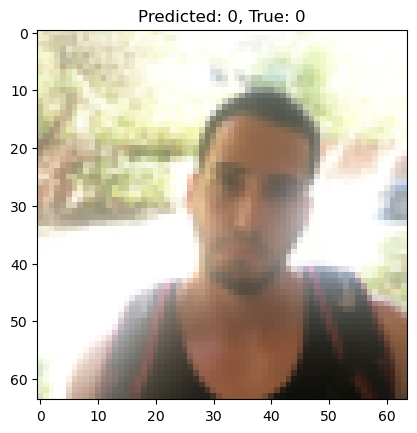

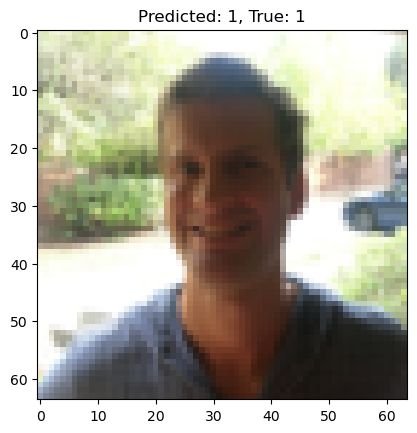

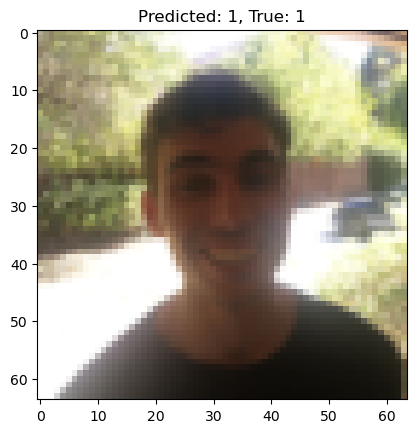

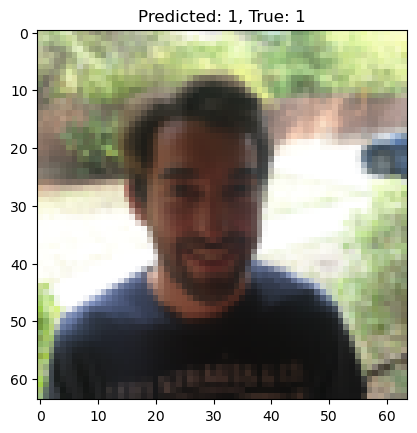

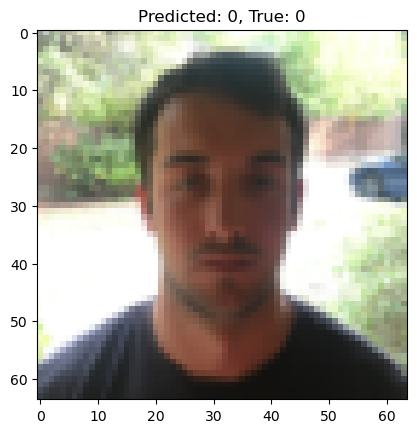

In [23]:
# Convert predicted probabilities to binary labels (0 for sad, 1 for happy)
predicted_labels = np.round(Y_pred_SGD)

# Display a random sample of images with predicted and true labels
num_samples = 5
random_indices = np.random.choice(range(len(X_test)), num_samples, replace=False)

for index in random_indices:
    # Display the image
    plt.imshow(X_test[index])
    plt.title(f'Predicted: {int(predicted_labels[index])}, True: {int(Y_test[index])}')
    plt.show()


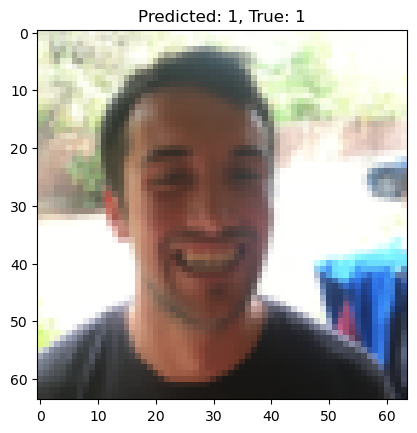

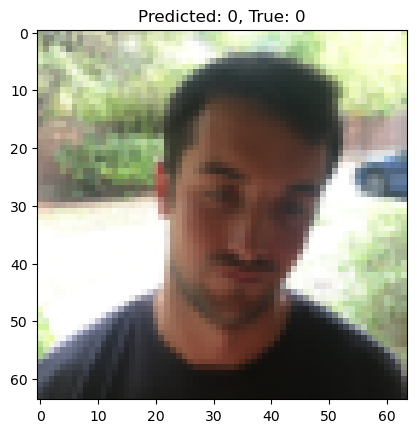

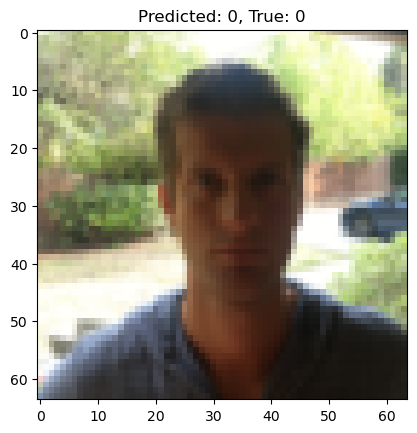

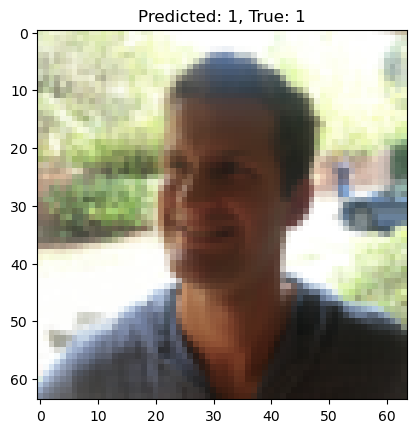

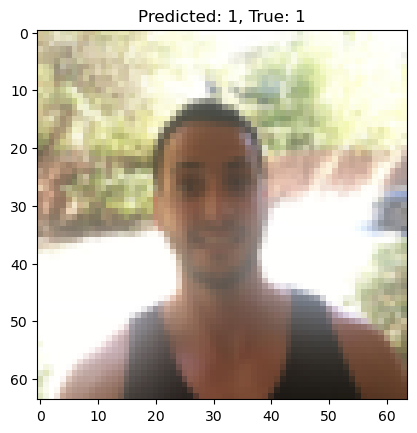

In [24]:
# Convert predicted probabilities to binary labels (0 for sad, 1 for happy)
predicted_labels = np.round(Y_pred_RMSprop)

# Display a random sample of images with predicted and true labels
num_samples = 5
random_indices = np.random.choice(range(len(X_test)), num_samples, replace=False)

for index in random_indices:
    # Display the image
    plt.imshow(X_test[index])
    plt.title(f'Predicted: {int(predicted_labels[index])}, True: {int(Y_test[index])}')
    plt.show()


-
-
-
-

we save the best model which is model_RMSprop

In [35]:
model_adam.save('happy_face_detector_adam')

INFO:tensorflow:Assets written to: happy_face_detector_adam\assets


INFO:tensorflow:Assets written to: happy_face_detector_adam\assets


In [36]:
model_SGD.save('happy_face_detector_SGD')

INFO:tensorflow:Assets written to: happy_face_detector_SGD\assets


INFO:tensorflow:Assets written to: happy_face_detector_SGD\assets


In [37]:
model_RMSprop.save('happy_face_detector_RMSprop')

INFO:tensorflow:Assets written to: happy_face_detector_RMSprop\assets


INFO:tensorflow:Assets written to: happy_face_detector_RMSprop\assets


In [38]:
def predict_smile(image_path, model):
    # Load the image
    image = Image.open(image_path)

    # Convert the image to RGB (if it's not in RGB format)
    image = image.convert('RGB')

    # Resize the image to 64x64 pixels
    image = image.resize((64, 64))

    # Convert the image to a NumPy array
    image_array = np.array(image)

    # Normalize pixel values (if needed)
    image_array = image_array / 255.0

    # Reshape the array to match the expected input shape of your model
    input_data = np.reshape(image_array, (1, 64, 64, 3))  # Assuming a color image (3 channels)

    # Make predictions
    predictions = model.predict(input_data)

    # Assuming binary classification (smiling or not smiling)
    predicted_class = "Smiling" if predictions[0][0] > 0.5 else "Not Smiling"

    print(f'Predictions: {predictions}')
    print(f'The model predicts: {predicted_class}')

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'The model predicts: {predicted_class}')
    plt.show()
